Step 0: Verify requirements:

* tensorflow
* transformers
* scikit-learn
* matplotlib
* seaborn

Step 1: Download dataset from Kaggle

URL: https://www.kaggle.com/datasets/zynicide/wine-reviews

In [1]:
#import kaggle
import pandas as pd

#kaggle.api.dataset_download_cli(dataset='zynicide/wine-reviews')

wine_df = pd.read_csv('data/winemag-data_first150k.csv')
print(wine_df.head())
corpus = wine_df['description']

   Unnamed: 0 country                                        description  \
0           0      US  This tremendous 100% varietal wine hails from ...   
1           1   Spain  Ripe aromas of fig, blackberry and cassis are ...   
2           2      US  Mac Watson honors the memory of a wine once ma...   
3           3      US  This spent 20 months in 30% new French oak, an...   
4           4  France  This is the top wine from La Bégude, named aft...   

                            designation  points  price        province  \
0                     Martha's Vineyard      96  235.0      California   
1  Carodorum Selección Especial Reserva      96  110.0  Northern Spain   
2         Special Selected Late Harvest      96   90.0      California   
3                               Reserve      96   65.0          Oregon   
4                            La Brûlade      95   66.0        Provence   

            region_1           region_2             variety  \
0        Napa Valley               

Step 2: Load a Pre-trained Transformer Model

Use the BERT model for generating contextual embeddings and Word2Vec for static embeddings.

In [2]:
import tensorflow as tf
import gensim.downloader as api
from transformers import BertTokenizer, TFBertModel

# Load pre-trained Word2Vec model
word2vec_model = api.load('word2vec-google-news-300')

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Step 3: Generate Text Embeddings

Static Embeddings with Word2Vec

In [3]:
import numpy as np

def generate_word2vec_embeddings(texts):
    embeddings = []
    for text in texts:
        tokens = text.lower().split()
        word_vectors = [word2vec_model[word] for word in tokens if word in word2vec_model]
        if word_vectors:
            embeddings.append(np.mean(word_vectors, axis=0))
        else:
            embeddings.append(np.zeros(word2vec_model.vector_size))
    return np.array(embeddings)

word2vec_embeddings = generate_word2vec_embeddings(corpus[:10])
print("Word2Vec Embeddings:", word2vec_embeddings)
print("Word2Vec Shape:", word2vec_embeddings.shape)

Word2Vec Embeddings: [[ 0.01978664  0.03414721 -0.00884628 ... -0.01573336  0.06626587
  -0.02784729]
 [ 0.0016861  -0.00124741 -0.00065494 ... -0.04453754  0.06408358
   0.03221512]
 [-0.01758194  0.06408924  0.02408564 ... -0.04092503  0.09110224
   0.01769352]
 ...
 [ 0.02863665  0.00169689 -0.00209213 ... -0.05629005  0.11204083
   0.03335422]
 [ 0.03364817  0.00603784 -0.03152262 ... -0.0193573   0.12829183
  -0.00842387]
 [ 0.01875126  0.03864291  0.00552817 ... -0.07643094  0.06591528
   0.01740489]]
Word2Vec Shape: (10, 300)


Contextual Embeddings with BERT

In [13]:
def generate_bert_embeddings(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='tf', padding=True, truncation=True)
        outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, 0, :])  # Use [CLS] token representation
    return np.array(embeddings).transpose(0,2,1)

bert_embeddings = generate_bert_embeddings(corpus[:10])
print("BERT Embeddings:", bert_embeddings)
print("Word2Vec Shape:", bert_embeddings.shape)

BERT Embeddings: [[[ 0.11967437]
  [-0.4885677 ]
  [ 0.3645302 ]
  ...
  [-0.43680477]
  [ 0.1197614 ]
  [ 0.18947843]]

 [[-0.05186629]
  [-0.36506557]
  [ 0.6474593 ]
  ...
  [-0.31474558]
  [ 0.05560149]
  [ 0.5154332 ]]

 [[-0.7317315 ]
  [ 0.35088482]
  [-0.01913851]
  ...
  [-0.03388324]
  [ 0.22656609]
  [ 0.30798084]]

 ...

 [[-0.35893542]
  [-0.5862951 ]
  [ 0.41342124]
  ...
  [-0.16299489]
  [ 0.33213347]
  [ 0.49520788]]

 [[-0.06120757]
  [-0.3186188 ]
  [ 0.66368055]
  ...
  [-0.26011455]
  [ 0.2298256 ]
  [ 0.4929128 ]]

 [[-0.79110813]
  [-0.3179432 ]
  [ 0.24998944]
  ...
  [-0.4293149 ]
  [ 0.30838776]
  [-0.06678592]]]
Word2Vec Shape: (10, 768, 1)


Step 4: Compute Similarity Between Embeddings

Use the scikit-learn library.

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

# Cosine similarity between Word2Vec embeddings
word2vec_similarity = cosine_similarity(word2vec_embeddings)
print("Word2Vec Cosine Similarity:\n", word2vec_similarity)

# Cosine similarity between BERT embeddings
bert_similarity = cosine_similarity(bert_embeddings.reshape(10,768))
print("BERT Cosine Similarity:\n", bert_similarity)

Word2Vec Cosine Similarity:
 [[1.         0.8253629  0.8051119  0.8419134  0.8391609  0.83854604
  0.821692   0.8248522  0.84638965 0.8140327 ]
 [0.8253629  1.0000001  0.7915442  0.8704566  0.7044301  0.8919623
  0.8556001  0.9090055  0.82102567 0.81991446]
 [0.8051119  0.7915442  0.99999994 0.781331   0.76637053 0.81088424
  0.7600281  0.786929   0.780628   0.82849413]
 [0.8419134  0.8704566  0.781331   0.9999998  0.7388935  0.8769781
  0.8692664  0.8658389  0.8299478  0.8144777 ]
 [0.8391609  0.7044301  0.76637053 0.7388935  0.99999994 0.7408405
  0.72642773 0.75437987 0.84104806 0.73225087]
 [0.83854604 0.8919623  0.81088424 0.8769781  0.7408405  1.0000001
  0.8641037  0.90941286 0.84747815 0.8254894 ]
 [0.821692   0.8556001  0.7600281  0.8692664  0.72642773 0.8641037
  1.0000001  0.8709889  0.8183165  0.78823984]
 [0.8248522  0.9090055  0.786929   0.8658389  0.75437987 0.90941286
  0.8709889  1.0000001  0.86063904 0.83889085]
 [0.84638965 0.82102567 0.780628   0.8299478  0.84104806

Step 5: Compare Contextual and Static Embeddings

Analyze and compare the similarity results from both BERT and Word2Vec embeddings.

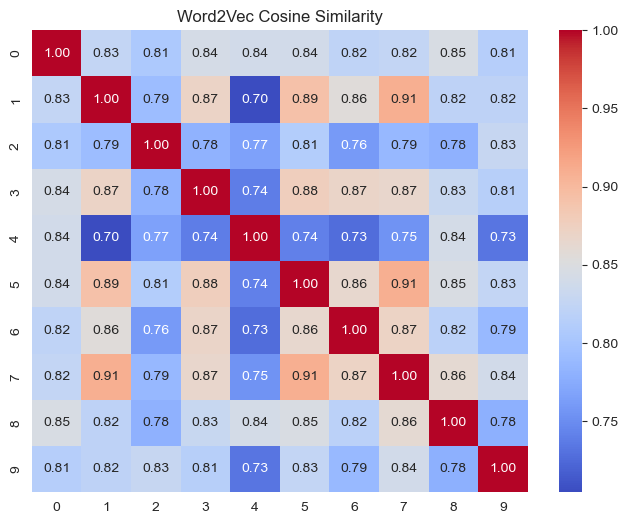

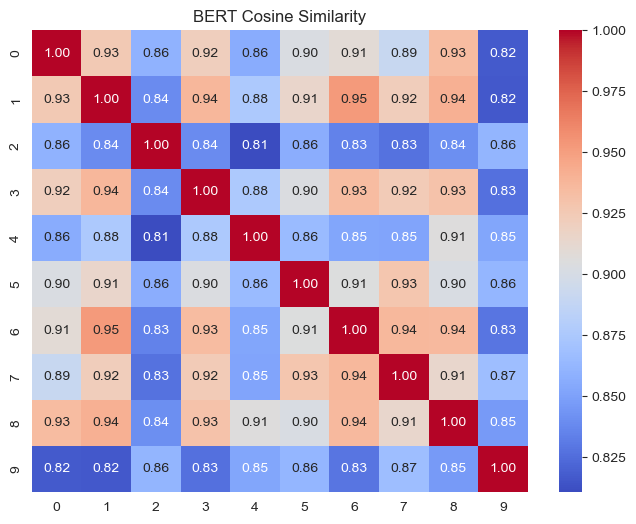

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity_matrix(matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(title)
    plt.show()

plot_similarity_matrix(word2vec_similarity, "Word2Vec Cosine Similarity")
plot_similarity_matrix(bert_similarity, "BERT Cosine Similarity")

Step 6: Applying to Corpus

In [ ]:
# Generate embeddings for the corpus
corpus_word2vec_embeddings = generate_word2vec_embeddings(corpus)
corpus_bert_embeddings = generate_bert_embeddings(corpus)

# Compute similarity for the corpus
corpus_word2vec_similarity = cosine_similarity(corpus_word2vec_embeddings)
corpus_bert_similarity = cosine_similarity(corpus_bert_embeddings.reshape(corpus_bert_embeddings.shape[:2]))

# Plot similarity matrices
plot_similarity_matrix(corpus_word2vec_similarity, "Corpus Word2Vec Cosine Similarity")
plot_similarity_matrix(corpus_bert_similarity, "Corpus BERT Cosine Similarity")

Summary

In this exercise, you learned how to:

* Load a pre-trained transformer model (BERT) and a static embedding model (Word2Vec).
* Generate text embeddings using these models.
* Compute cosine similarity between embeddings.
* Compare the similarity results from both contextual and static embeddings.

This hands-on exercise provides a practical understanding of how transformers and embeddings can be used in Information Retrieval systems.

Step 7: Generate Embeddings for the Query

Generate embeddings for the query using the same model used for the documents.

Step 8: Compute Similarity Between Query and Documents

Compute the similarity between the query embedding and each document embedding.

Step 4: Retrieve and Rank Documents Based on Similarity Scores

Retrieve and rank the documents based on their similarity scores to the query.